## Финальное соревнование

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

В данном задании вас ждет неизвестная зависимость. Ваша основная задача: **построить две лучших модели**, минимизирующих среднеквадратичную ошибку (MSE):
1. На первую модель не налагается ограничений.
2. Вторая модель должна быть **линейной**, т.е. представлять собой линейную комбинацию признаков плюс свободный член: $\boldsymbol{w}^{\top}\boldsymbol{x} + b$. При этом __вы можете использовать базовые математические операции для преобразования признаков__: np.exp, np.log, np.pow (полный список доступен в [документации](https://numpy.org/doc/stable/reference/routines.math.html)), а также линейные операции над ними (сумма, умножение на число и пр.). Для преобразования признаков вам будет необходимо написать функцию `my_transformation`. __Кол-во параметров (весов) используемых второй моделью не должно превышать 15 (включая свободный член).__

Настоятельно рекомендуем написать код "с нуля", лишь поглядывая на готовые примеры, а не просто "скопировать-вставить". Это поможет вам в будущем писать код более уверенно

In [1]:
import os
import json

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

from xgboost import XGBRegressor

In [2]:
random_state = 42

Загрузка данных происходит ниже. Если она не срабатывает, самостоятельно скачайте файл `hw_final_open_data.npy` и положите его в ту же директорию, что и ноутбук.

In [3]:
# !wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_yandex_ml_trainings/homeworks/assignment_final/hw_final_open_data.npy -O hw_final_open_data.npy
# !wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_yandex_ml_trainings/homeworks/assignment_final/hw_final_open_target.npy -O hw_final_open_data.npy

In [4]:
assert os.path.exists('hw_final_open_data.npy'), 'Please, download `hw_final_open_data.npy` and place it in the working directory'
assert os.path.exists('hw_final_open_target.npy'), 'Please, download `hw_final_open_target.npy` and place it in the working directory'
data = np.load('hw_final_open_data.npy', allow_pickle=False)
target = np.load('hw_final_open_target.npy', allow_pickle=False)

In [5]:
def plot_feature_distributions(data, target):
    num_features = data.shape[1]
    num_rows = int(np.ceil((num_features + 1) / 2))
    num_cols = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 3 * num_rows))
    for i in range(num_features):
        row_idx = i // num_cols
        col_idx = i % num_cols
        sns.kdeplot(data[:, i], fill=True, ax=axes[row_idx, col_idx])
        axes[row_idx, col_idx].set_title(f'Feature {i}')
        axes[row_idx, col_idx].set_xlabel('Value')
        axes[row_idx, col_idx].set_ylabel('Density')
    row_idx = num_features // num_cols
    col_idx = num_features % num_cols
    sns.kdeplot(target, fill=True, ax=axes[row_idx, col_idx])
    axes[row_idx, col_idx].set_title('Target')
    axes[row_idx, col_idx].set_xlabel('Value')
    axes[row_idx, col_idx].set_ylabel('Density')
    for i in range(num_features + 1, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])
    plt.tight_layout()
    plt.show()

In [6]:
def plot_correlation_matrix(data, target):
    combined_data = np.column_stack((data, target))
    correlation_matrix = np.corrcoef(combined_data, rowvar=False)
    plt.figure(figsize=(13, 5))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.6f', 
                xticklabels=[f'Feature {i}' for i in range(data.shape[1])] + ['Target'],
                yticklabels=[f'Feature {i}' for i in range(data.shape[1])] + ['Target'])
    plt.title('Correlation Matrix')
    plt.show()

### Модель №1
Напоминаем, в первой части задания ваша основная задача – получить наилучший результат без ограничений на модель. Сдаваться будут только предсказания модели.

Пример с использованием Random Forest доступен ниже.

In [7]:
# data normalization
scaler = StandardScaler()
data = scaler.fit_transform(data)

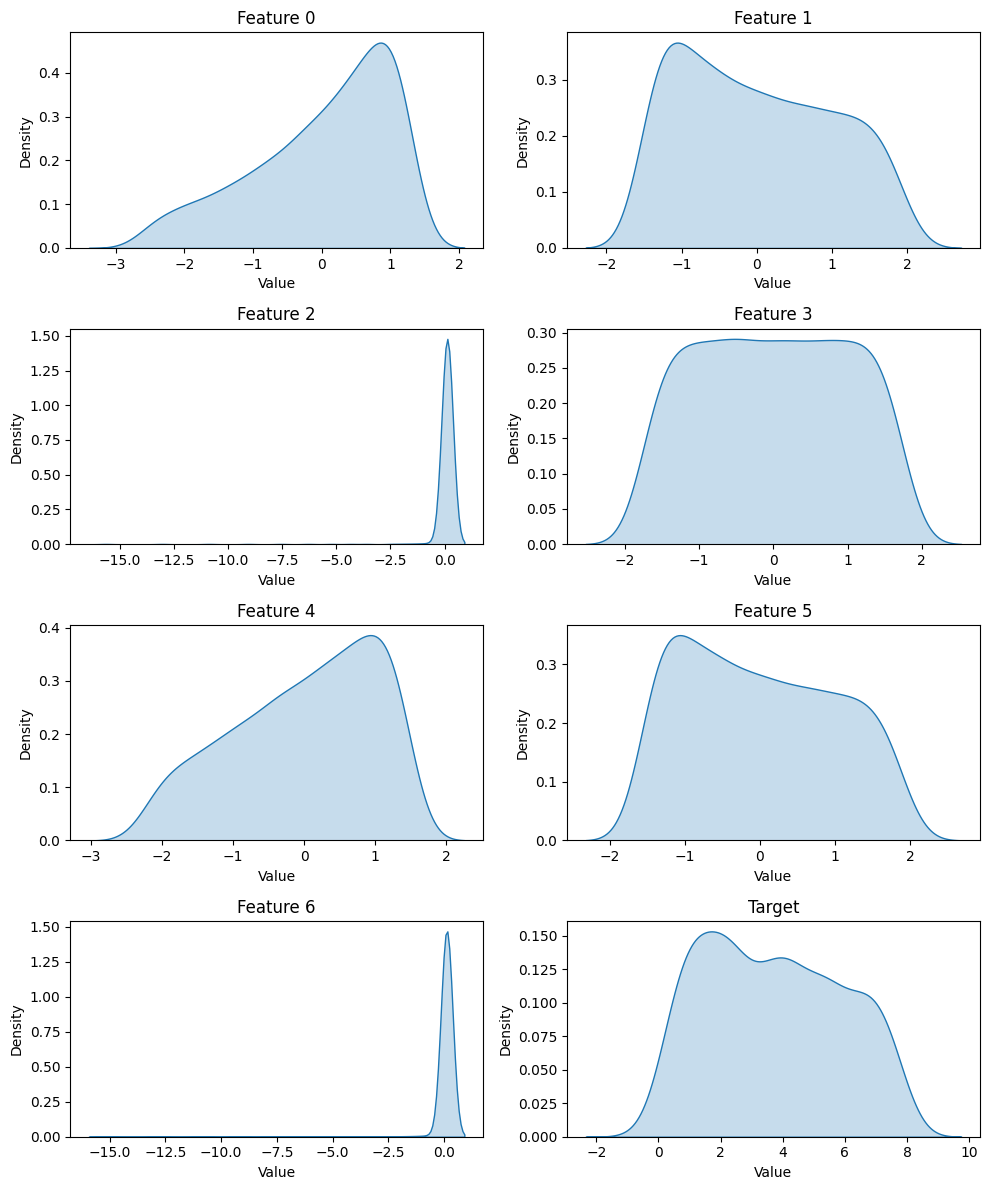

In [8]:
# feture distribution
plot_feature_distributions(data, target)

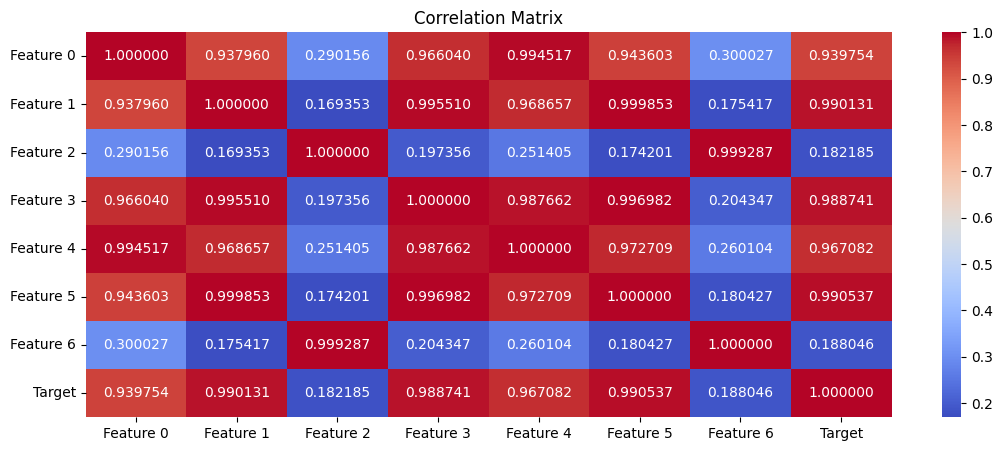

In [9]:
# correlation matrix
plot_correlation_matrix(data, target)

In [10]:
# feature selection
feature_importance_model = RandomForestRegressor(random_state=random_state)
feature_importance_model.fit(data, target)
feature_importances = feature_importance_model.feature_importances_
print('Feature importances:', *feature_importances)
sfm = SelectFromModel(feature_importance_model, threshold=0.001)
data = sfm.fit_transform(data, target)
selected_features = np.where(sfm.get_support())[0]
print("Selecteed features:", *selected_features)

Feature importances: 0.22651978296910244 0.21724173571903263 0.0002784140243243634 0.15883214577900054 0.17458186596931982 0.2218645821708776 0.0006814733683425791
Selecteed features: 0 1 3 4 5


In [11]:
# model
base_models = [
    ('Ridge', Ridge(random_state=random_state)),
    ('XGBRegressor', XGBRegressor(random_state=random_state, n_jobs=-1))
]

meta_model = LinearRegression()

model = StackingRegressor(estimators=base_models, final_estimator=meta_model)

In [12]:
# cross validation
k_fold = KFold(n_splits=10, shuffle=True, random_state=random_state)
cv_scores = -cross_val_score(model, data, target, cv=k_fold, scoring='neg_mean_squared_error', n_jobs=-1)
mse = cv_scores.mean()
print(f"Mean MSE: {mse:.4f}")
print(f"Points: {(1 - mse) * 1.5:.4f}")
print(f"STD MSE: {cv_scores.std():.4f}")
baseline_mse = 0.3467
print(f'Baseline MSE: {baseline_mse}')
print(f'Baseline points: {(1 - baseline_mse) * 1.5:.4f}')

Mean MSE: 0.0908
Points: 1.3638
STD MSE: 0.0154
Baseline MSE: 0.3467
Baseline points: 0.9799


In [13]:
# model fitting
model.fit(data, target)

StackingRegressor(estimators=[('Ridge', Ridge(random_state=42)),
                              ('XGBRegressor',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=-1,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                  final_estimator=LinearRegression())

##### Сдача первой части соревнования
Загрузите файл `hw_final_closed_data.npy` (ссылка есть на странице с заданием). Если вы используете sklearn-совместимую модель, для генерации посылки вы можете воспользоваться функцией `get_predictions`. В ином случае перепишите функцию для вашей модели и запустите код под следующей ячейкой для генерации посылки.

In [14]:
# !wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_yandex_ml_trainings/homeworks/assignment_final/hw_final_closed_data.npy -O hw_final_closed_data.npy

In [15]:
assert os.path.exists('hw_final_closed_data.npy'), 'Please, download `hw_final_closed_data.npy` and place it in the working directory'
closed_data = np.load('hw_final_closed_data.npy', allow_pickle=False)

Если необходимо, преобразуйте данные. Преобразованную матрицу объект-признак сохраните в переменную `closed_data`.

In [16]:
# data normalization
closed_data = scaler.transform(closed_data)
# feature selection
closed_data = sfm.transform(closed_data)

In [17]:
def get_predictions(model, eval_data, step=10):
    predicted_values = model.predict(eval_data)
    return predicted_values

Обращаем ваше внимание, предсказания округляются до сотых!

In [18]:
predicted_values = np.round(get_predictions(model=model, eval_data=closed_data), 2)

assert predicted_values.shape == (closed_data.shape[0], ) # predictions should be just one-dimensional array

In [19]:
# do not change the code in the block below
# __________start of block__________
def float_list_to_comma_separated_str(_list):
    _list = list(np.round(np.array(_list), 2))
    return ','.join([str(x) for x in _list])

submission_dict = {
    'predictions': float_list_to_comma_separated_str(predicted_values)
}
with open('submission_dict_final_p01.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
    
print('File saved to `submission_dict_final_p01.npy`')
# __________end of block__________

File saved to `submission_dict_final_p01.npy`


### Модель №2
Функция `my_transformation` принимает на вход матрицу объект-признак (`numpy.ndarray` типа `np.float`) и преобразует ее в новую матрицу. Данная функция может использовать только numpy-операции, а также арифметические действия.

Для примера доступна функция ниже. Она лишь добавляет новый признак, представляющий собой произведение первого и второго исходных признаков (считая с нуля).

In [20]:
import os
import json
import math

import numpy as np

import optuna

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge, LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

from xgboost import XGBRegressor

In [21]:
random_state = 42

In [22]:
data = np.load('hw_final_open_data.npy', allow_pickle=False)
target = np.load('hw_final_open_target.npy', allow_pickle=False)

In [23]:
def my_transformation(data: np.ndarray):
    # new_feature_matrix = np.zeros((feature_matrix.shape[0], feature_matrix.shape[1]+1))
    # new_feature_matrix[:, :feature_matrix.shape[1]] = feature_matrix
    # new_feature_matrix[:, -1] = feature_matrix[:, 0] * feature_matrix[:, 1]
    data = (data - np.array([-5.62410914e-01,  2.58281096e-01, -5.68630481e-01, -6.69724427e-04,
       -5.00564651e-01,  1.51947504e+00, -5.75437567e-01])) * np.array([5.16195921e+02, 1.94217464e+00, 3.64271476e+08, 3.88311869e+00,
       6.18311049e+01, 8.10959916e-01, 2.74664694e+08])
    result = np.c_[data, np.sin(np.pi * data[:, 0])]
    # result = np.c_[result, data[:, 0], data[:, 1], data[:, 5]]
    return result

In [24]:
data = my_transformation(data)

In [25]:
# feature selection
# feature_importance_model = RandomForestRegressor(random_state=random_state)
# feature_importance_model.fit(data, target)
# feature_importances = feature_importance_model.feature_importances_
# print('Feature importances:', feature_importances)
# sfm = SelectFromModel(feature_importance_model, threshold=0.2)
# data = sfm.fit_transform(data, target)
# selected_features = np.where(sfm.get_support())[0]
# print("Selecteed features:", selected_features)

In [26]:
X_train, X_val, y_train, y_val = train_test_split(data, target, test_size=0.25, random_state=random_state)
def objective(trial):
    alpha = trial.suggest_float('alpha', 0.01, 2.0, log=True)
    l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=5000, random_state=random_state)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    return mse
    
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)

In [27]:
# model
model = ElasticNet(**study.best_params, max_iter=5000, random_state=random_state)

In [28]:
# cross validation
k_fold = KFold(n_splits=10, shuffle=True, random_state=random_state)
cv_scores = -cross_val_score(model, data, target, cv=k_fold, scoring='neg_mean_squared_error', n_jobs=-1)
mse = cv_scores.mean()
print(f"Mean MSE: {mse:.4f}")
print(f"Points: {(1 - mse) * 1.5:.4f}")
print(f"STD MSE: {cv_scores.std():.4f}")
baseline_mse = 0.0905
print(f'Baseline MSE: {baseline_mse}')
print(f'Baseline points: {(1 - baseline_mse) * 1.5:.4f}')

Mean MSE: 0.0913
Points: 1.3630
STD MSE: 0.0148
Baseline MSE: 0.0905
Baseline points: 1.3642


In [29]:
# model fitting
model.fit(data, target)

ElasticNet(alpha=0.010004839544112692, l1_ratio=0.0005114873287215903,
           max_iter=5000, random_state=42)

In [30]:
original_predictions = model.predict(data)
rounded_predictions = data.dot(np.round(model.coef_.squeeze(), 4)) + np.round(model.intercept_.squeeze(), 4)

assert np.allclose(original_predictions, rounded_predictions, atol=1e-3)

In [31]:
w_list = list(np.round(model.coef_.squeeze(), 4))
print(f'w_submission = {list(np.round(model.coef_.squeeze(), 4))}\nb_submission = {np.round(model.intercept_.squeeze(), 4)}')

w_submission = [-0.0471, 0.7544, 0.0, 0.553, 0.195, 0.7188, 0.0015, -0.0227]
b_submission = 3.7105


In [32]:
assert len(w_list) + 1 <= 15